# Bellman-Ford

## Implementation of basic structures and algorithm

In [5]:
mutable struct WEdge
    u::Int
    v::Int
    w::Float64
end

mutable struct WGraph
    adj::Dict{Int, Vector{WEdge}}
end

function addedge!(g::WGraph, u::Int, v::Int, w::Float64)
    if !haskey(g.adj, u)
        g.adj[u] = Vector{WEdge}()
    end
    if !haskey(g.adj, v)
        g.adj[v] = Vector{WEdge}()
    end

    push!(g.adj[u], WEdge(u, v, w))
end

# Init single source function
function initsinglesource(graph::WGraph, s::Int)
    dist = Dict{Int, Float64}()
    pred = Dict{Int, Union{Int, Nothing}}()
    for v in keys(graph.adj)
        dist[v] = Inf
        pred[v] = nothing
    end
    dist[s] = 0.0

    return dist, pred
end

# Relaxing function
function relax!(dist::Dict{Int, Float64}, pred::Dict{Int, Union{Int, Nothing}}, u::Int, v::Int, w::Float64)
    if dist[v] > dist[u] + w
        dist[v] = dist[u] + w
        pred[v] = u
    end
end

# Bellman-Ford algorithm
function bellmanford(graph::WGraph, s::Int)
    dist, pred = initsinglesource(graph, s)
    V = keys(graph.adj)

    for _ in 1:(length(V) - 1)
        for u in V
            for edge in graph.adj[u]
                relax!(dist, pred, edge.u, edge.v, edge.w)
            end
        end
    end

    # Check for negative-weight cycles
    for u in V
        for edge in graph.adj[u]
            if dist[edge.v] > dist[edge.u] + edge.w
                return false, dist, pred
            end
        end
    end

    return true, dist, pred
end

bellmanford (generic function with 1 method)

## Experiment functions

In [6]:
using Random
using BenchmarkTools
using Statistics

function generate_weighted_graph(n::Int, edge_prob::Float64)
    g = WGraph(Dict{Int, Vector{WEdge}}())
    for u in 1:n
        for v in 1:n
            if u != v && rand() < edge_prob
                w = rand(-5.0:1.0:10.0)
                addedge!(g, u, v, w)
            end
        end
    end

    return g
end

function estimate_instances_bf(graph::WGraph, s::Int, target_time::Float64)
    test_instances = 3
    instance_times = [@elapsed bellmanford(graph, s) for _ in 1:test_instances]
    avg_time = mean(instance_times)

    estimate_instances = max(1, Int(round(target_time / avg_time)))
    return estimate_instances
end

function measure_bf_time(graph::WGraph, s::Int, target_time::Float64)
    instances = estimate_instances_bf(graph, s, target_time)
    instance_times = [@elapsed bellmanford(graph, s) for _ in 1:instances]

    avg_time = mean(instance_times)
    median_time = median(instance_times)
    total_time = sum(instance_times)

    return avg_time, median_time, total_time, instances, instance_times
end

function run_bellmanford_experiment(edge_prob::Float64 = 0.8, target_time::Float64 = 20.0)
    sizes = [50, 100, 200, 400, 600, 800, 1000, 1200]
    all_times = Vector{Vector{Float64}}()

    for size in sizes
        println("Measuring Bellman-Ford for size $size")
        g = generate_weighted_graph(size, edge_prob)
        avg_time, median_time, total_time, instances, instance_times = measure_bf_time(g, 1, target_time)
        println("Instances: $instances | Avg time: $avg_time s | Median time: $median_time s |Total time: $total_time s")
        push!(all_times, instance_times)
    end

    return all_times
end

run_bellmanford_experiment (generic function with 3 methods)

## Run experiment and generate violin plot

Measuring Bellman-Ford for size 50
Instances: 244523 | Avg time: 0.0009237539932848853 s | Median time: 0.0008799 s |Total time: 225.8790977 s
Measuring Bellman-Ford for size 100
Instances: 46719 | Avg time: 0.008824233132130398 s | Median time: 0.0086606 s |Total time: 412.25934770000003 s
Measuring Bellman-Ford for size 200
Instances: 5344 | Avg time: 0.07968495224550899 s | Median time: 0.07651764999999999 s |Total time: 425.8363848 s
Measuring Bellman-Ford for size 400
Instances: 603 | Avg time: 0.6896170033167496 s | Median time: 0.6873289 s |Total time: 415.839053 s
Measuring Bellman-Ford for size 600
Instances: 158 | Avg time: 3.353552606329113 s | Median time: 3.6039359500000003 s |Total time: 529.8613117999998 s
Measuring Bellman-Ford for size 800
Instances: 55 | Avg time: 6.172221136363637 s | Median time: 5.3879454 s |Total time: 339.4721625 s
Measuring Bellman-Ford for size 1000
Instances: 41 | Avg time: 10.354386907317075 s | Median time: 10.3258439 s |Total time: 424.5298

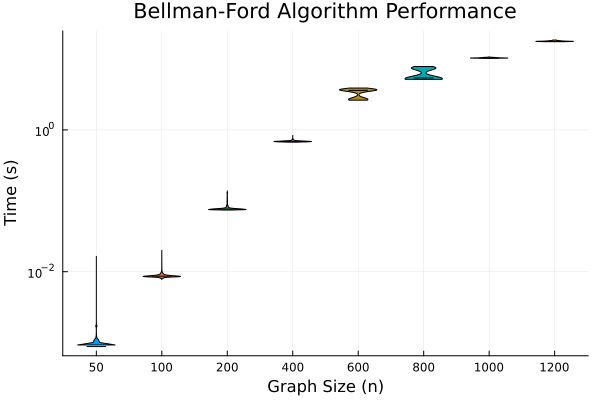

In [7]:
using StatsPlots
using Dates

times = run_bellmanford_experiment(0.5, 420.0)
sizes_series = ["50" "100" "200" "400" "600" "800" "1000" "1200"]

violin(
    sizes_series,
    times,
    xlabel = "Graph Size (n)",
    ylabel = "Time (s)",
    title = "Bellman-Ford Algorithm Performance",
    show_median = true,
    legend = false,
    yscale = :log10,
)

In [8]:
savefig("plots/bellman_ford_violin_plot_$(Dates.format(Dates.now(), "yyyymmdd_HHMM")).png")

"c:\\VSCodeProjects\\Julia\\path-finding\\plots\\bellman_ford_violin_plot_20250419_1622.png"